In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 0 
set_all_seeds(seed)

Using device: cuda


In [3]:
from potentials.EntropicSwitchTrippleWellPotential import EntropicSwitchTrippleWellPotential
from simulations.AMSSimulation import AMSLangevin

In [4]:
from committor.neural_net_models import CommittorMultiDecoder
from committor.train_committor import TainCommittorMultipleDecoder

In [5]:
pot = EntropicSwitchTrippleWellPotential()
pot.set_2D_plot_grid_precision(200, 200)

committor = CommittorMultiDecoder([4, 20, 20, 1], [1, 20, 20, 4], pot)

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

In [6]:
MEP_1 = [pot.minimum_energy_paths[0][0]]
i = 1
while i < len(pot.minimum_energy_paths[0]):
    if np.sqrt(np.sum((MEP_1[-1] - pot.minimum_energy_paths[0][i])**2)) > pot.dx:
        MEP_1.append(pot.minimum_energy_paths[0][i])
    i += 1
MEP_1 = np.array(MEP_1)
MEP_2 = [pot.minimum_energy_paths[1][0]]
i = 1
while i < len(pot.minimum_energy_paths[1]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[1][i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[1][i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[2]):
    if np.sqrt(np.sum((MEP_2[-1] - pot.minimum_energy_paths[2][-i])**2)) > pot.dx:
        MEP_2.append(pot.minimum_energy_paths[2][-i])
    i += 1
MEP_2 = np.array(MEP_2)

In [7]:
beta = 4
dt = 0.01
AMS_on_ES = AMSLangevin(pot, M = np.ones([1,2]), gamma=0.1, xi=None, beta=beta, forward=True, dt=dt, threshold=10**(-8))

In [8]:
## Generate 100 penalization points on each boundary of R and P
R_radius = pot.R_radius
P_radius = pot.P_radius
theta = np.random.uniform(0,np.pi, size=[100])
p_x = np.random.normal(scale=1/beta, size=[100])
p_y = np.random.normal(scale=1/beta, size=[100])
pen_points = np.append(np.append(np.append(pot.minR, np.zeros(2)) + np.array([R_radius * np.cos(theta), R_radius * np.sin(theta), p_x, p_y]).T, np.zeros([100, 1]), axis=1), np.append(np.append(pot.minP, np.zeros(2)) + np.array([P_radius * np.cos(theta), P_radius * np.sin(theta), p_x, p_y]).T, np.ones([100, 1]), axis=1), axis=0)


In [9]:
n_conditions = 20
n_rep = 20
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ES.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ES.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ES.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ES.set_forward(True)
print(n_steps_b + n_steps_f)

7918


In [10]:
N = 200 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [],
           "single_trajs_mom": [],
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           'dt': dt, 'beta': beta}

i = 0
while i < len(ini_traj_f["x_traj"]) - N:
    x_traj = []
    p_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_f["x_traj"][i]) or pot.in_R(ini_traj_f["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_f["x_traj"][i:i+1])
    p_traj.append(ini_traj_f["p_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_f["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_f["x_traj"][n+i:n+i+1]) 
                p_traj.append(ini_traj_f["p_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_f["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                p_traj.append(p_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_f["x_traj"][n+i]) or pot.in_R(ini_traj_f["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_f["x_traj"][n+i:n+i+1]
                    p_end = ini_traj_f["p_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_mom"].append(p_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
i = 0
while i < len(ini_traj_b["x_traj"]) - N:
    x_traj = []
    p_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_b["x_traj"][i]) or pot.in_R(ini_traj_b["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_b["x_traj"][i:i+1])
    p_traj.append(ini_traj_b["p_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_b["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_b["x_traj"][n+i:n+i+1]) 
                p_traj.append(ini_traj_b["p_traj"][n+i:n+i+1])
                gauss_traj.append(ini_traj_b["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                p_traj.append(p_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_b["x_traj"][n+i]) or pot.in_R(ini_traj_b["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_b["x_traj"][n+i:n+i+1]
                    p_end = ini_traj_b["p_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_b["x_traj"])
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_mom"].append(p_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["single_trajs_mom"] = np.array(dataset["single_trajs_mom"])[:, :, 0, :]

In [11]:
dataset["single_trajs_pos"].shape

(61, 201, 2)

In [12]:
committor_training = TainCommittorMultipleDecoder(committor, pot, dataset, penalization_points=pen_points)
committor_training.train_test_split(train_size= 50)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**0
loss_params["n_wait"] = 50

committor_training.set_loss_weight(loss_params)
batch_size = 10
max_epochs = 1000

log_ito_loss_weight value not provided, set to default value of:  0.0
strahan_loss_weight value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


In [13]:
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 1000 epochs.



In [14]:
np.min(loss_dict["test_ito_loss"])

2.9731089e-05

/tmp/ipykernel_9820/3471631711.py:19: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_9820/3471631711.py:37: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


<Figure size 432x288 with 0 Axes>

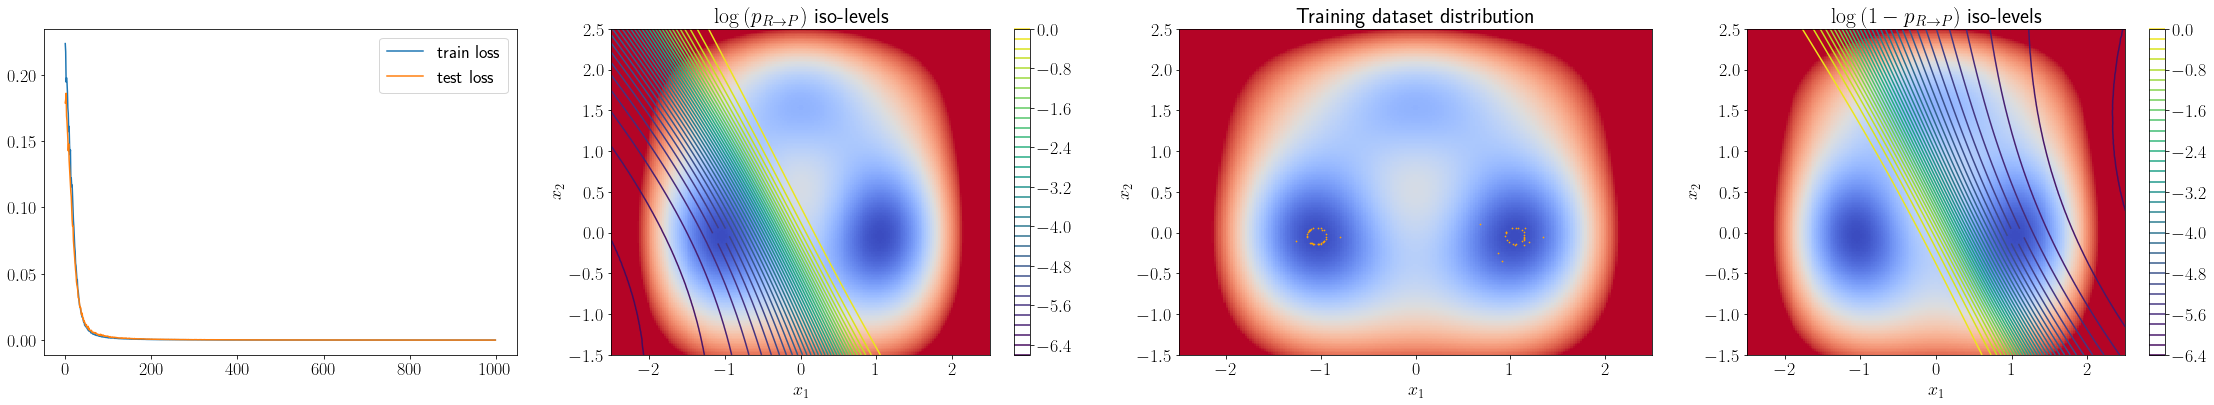

In [16]:
fig = plt.figure()
x = pot.x2d 
#x_and_p = np.append(x, np.zeros_like(x), axis=1)
x_and_p = np.append(x, np.random.normal(scale=1/beta, size=pot.x2d.shape[1]) * np.ones_like(x), axis=1)
xi_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(39, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title(r'$ \log \left( p_{R\rightarrow P} \right) $ iso-levels')
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.set_title(r'Training dataset distribution')

ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
#ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'$x_2$')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title(r'$ \log \left(1-p_{R\rightarrow P} \right) $ iso-levels')
plt.savefig("ES_itarative_AMS.png", format='png', dpi=160)

In [17]:
def xi_forward(x,p):
    X = np.append(x, p, axis=1)
    return(committor_training.committor_model.xi_forward(X))

def xi_backward(x,p):
    X = np.append(x, p, axis=1)
    return(committor_training.committor_model.xi_backward(X))

In [18]:
AMS_on_ES.set_xi(xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ES.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ES.set_forward(False)
AMS_on_ES.set_xi(xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ES.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ES.set_forward(True)

In [19]:
print(p_f)
print(p_b)

1.8625991265286687e-07
2.963545834667868e-07


Add the new sampled trajectories to the dataset

In [20]:
N = 200 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_mom": [],
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}
for j in range(0, len(replicas_f)):
    i = 0
    while i < len(replicas_f[j]["x_traj"]) - N:
        x_traj = []
        p_traj = []
        gauss_traj = []
        while pot.in_P(replicas_f[j]["x_traj"][i]) or pot.in_R(replicas_f[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_f[j]["x_traj"][i:i+1])
        p_traj.append(replicas_f[j]["p_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_f[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_f[j]["x_traj"][n+i:n+i+1]) 
                    p_traj.append(replicas_f[j]["p_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_f[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    p_traj.append(p_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_f[j]["x_traj"][n+i]) or pot.in_R(replicas_f[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_f[j]["x_traj"][n+i:n+i+1]
                        p_end = replicas_f[j]["p_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_f[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_mom"].append(p_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
for j in range(0, len(replicas_b)):
    i = 0
    while i < len(replicas_b[j]["x_traj"]) - N:
        x_traj = []
        p_traj = []
        gauss_traj = []
        while pot.in_P(replicas_b[j]["x_traj"][i]) or pot.in_R(replicas_b[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_b[j]["x_traj"][i:i+1])
        p_traj.append(replicas_b[j]["p_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_b[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_b[j]["x_traj"][n+i:n+i+1]) 
                    p_traj.append(replicas_b[j]["p_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_b[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    p_traj.append(p_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_b[j]["x_traj"][n+i]) or pot.in_R(replicas_b[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_b[j]["x_traj"][n+i:n+i+1]
                        p_end = replicas_b[j]["p_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_b[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_mom"].append(p_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])

In [21]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)
dataset["single_trajs_mom"] = np.append(dataset["single_trajs_mom"], np.array(dset["single_trajs_mom"])[:, :, 0, :], axis=0)

In [22]:
dataset["single_trajs_pos"].shape

(3083, 201, 2)

In [23]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size= 30 * 10**2)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001)
batch_size = 10**2
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 478 epochs.



In [24]:
np.min(loss_dict["test_ito_loss"])

0.009181564

/tmp/ipykernel_9820/3471631711.py:19: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_9820/3471631711.py:37: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


<Figure size 432x288 with 0 Axes>

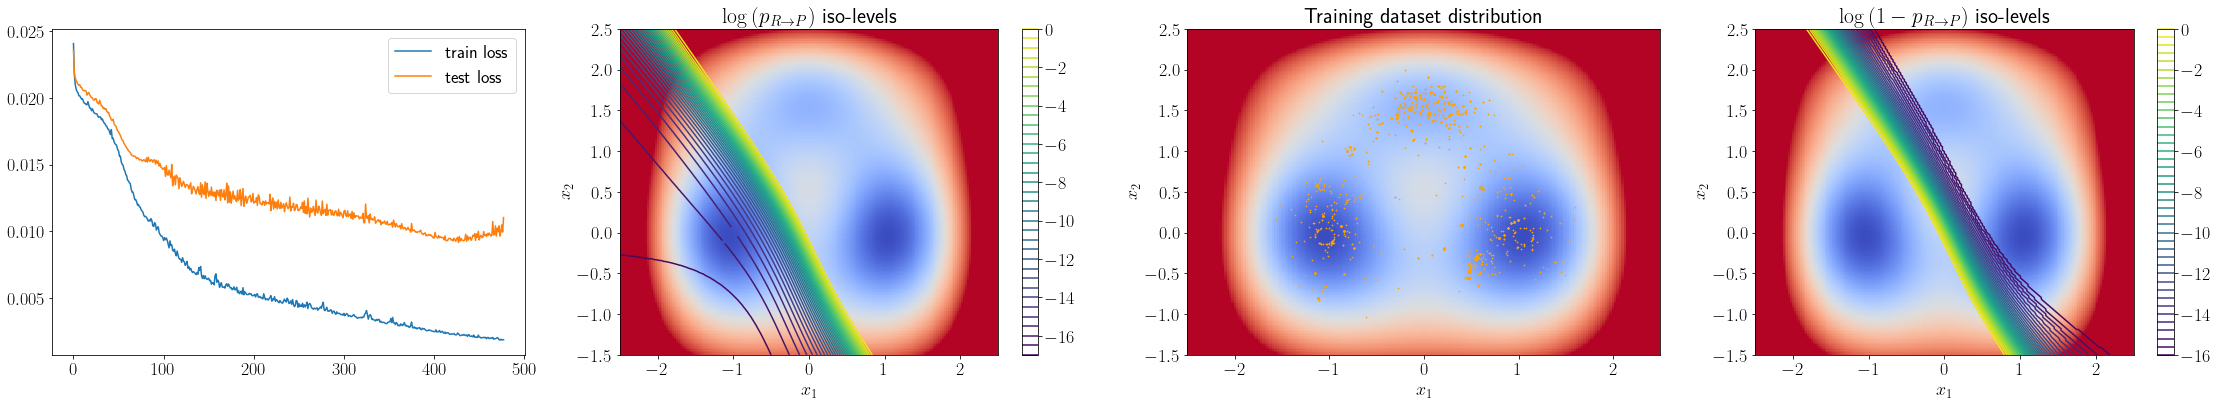

In [29]:
fig = plt.figure()
x = pot.x2d 
#x_and_p = np.append(x, np.zeros_like(x), axis=1)
x_and_p = np.append(x, np.random.normal(scale=1/beta, size=pot.x2d.shape[1]) * np.ones_like(x), axis=1)
xi_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(39, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title(r'$ \log \left( p_{R\rightarrow P} \right) $ iso-levels')
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.set_title(r'Training dataset distribution')

ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
#ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'$x_2$')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title(r'$ \log \left(1-p_{R\rightarrow P} \right) $ iso-levels')
plt.savefig("ES_itarative_AMS.png", format='png', dpi=160)

## New iteration of the learning procedure. 

In [31]:
n_conditions = 50
n_rep = 50
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_ES.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ES.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_ES.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_ES.set_forward(True)
print(n_steps_b + n_steps_f)

19685


In [32]:
N = 200 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [],
           "single_trajs_mom": [],
           "single_trajs_gauss": [], 
           "single_trajs_weights": []}

i = 0
while i < len(ini_traj_f["x_traj"]) - N:
    x_traj = []
    p_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_f["x_traj"][i]) or pot.in_R(ini_traj_f["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_f["x_traj"][i:i+1])
    p_traj.append(ini_traj_f["p_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_f["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_f["x_traj"][n+i:n+i+1]) 
                p_traj.append(ini_traj_f["p_traj"][n+i:n+i+1]) 
                gauss_traj.append(ini_traj_f["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                p_traj.append(p_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_f["x_traj"][n+i]) or pot.in_R(ini_traj_f["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_f["x_traj"][n+i:n+i+1]
                    p_end = ini_traj_f["p_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_f["x_traj"])
    dset["single_trajs_pos"].append(x_traj)
    dset["single_trajs_mom"].append(p_traj)
    dset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dset["single_trajs_weights"].append([boudary_weight])
    else:
        dset["single_trajs_weights"].append([1.])
i = 0
while i < len(ini_traj_b["x_traj"]) - N:
    x_traj = []
    p_traj = []
    gauss_traj = []
    while pot.in_P(ini_traj_b["x_traj"][i]) or pot.in_R(ini_traj_b["x_traj"][i]):
        i += 1
    x_traj.append(ini_traj_b["x_traj"][i:i+1])
    p_traj.append(ini_traj_b["p_traj"][i:i+1])
    end_in_R_or_P = False
    n = 1
    if i < len(ini_traj_b["x_traj"]) - N:
        while n <= N:
            if not end_in_R_or_P:
                x_traj.append(ini_traj_b["x_traj"][n+i:n+i+1]) 
                p_traj.append(ini_traj_b["p_traj"][n+i:n+i+1])
                gauss_traj.append(ini_traj_b["gauss_traj"][n+i:n+i+1])
            else:
                x_traj.append(x_end)
                p_traj.append(p_end)
                gauss_traj.append(np.zeros_like(x_end))
            if pot.in_P(ini_traj_b["x_traj"][n+i]) or pot.in_R(ini_traj_b["x_traj"][n+i]):
                if not end_in_R_or_P:
                    n_max = n
                    x_end = ini_traj_b["x_traj"][n+i:n+i+1]
                    p_end = ini_traj_b["p_traj"][n+i:n+i+1]
                end_in_R_or_P = True 
            n += 1
        if end_in_R_or_P:
            i += n_max + 1
        else: 
            i += N + 1
    else:
        i = len(ini_traj_b["x_traj"])
    dset["single_trajs_pos"].append(x_traj)
    dset["single_trajs_mom"].append(p_traj)
    dset["single_trajs_gauss"].append(gauss_traj)
    if end_in_R_or_P:
        dset["single_trajs_weights"].append([boudary_weight])
    else:
        dset["single_trajs_weights"].append([1.])

In [33]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)
dataset["single_trajs_mom"] = np.append(dataset["single_trajs_mom"], np.array(dset["single_trajs_mom"])[:, :, 0, :], axis=0)

In [34]:
dataset["single_trajs_pos"].shape

(3240, 201, 2)

In [35]:
committor_training.committor_model.to('cuda:0')
AMS_on_ES.set_xi(xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_ES.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ES.set_forward(False)
AMS_on_ES.set_xi(xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_ES.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_ES.set_forward(True)

In [36]:
print(p_f)
print(p_b)

0.0
1.0587730958685781e-06


In [37]:
N = 200 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dset = {"single_trajs_pos": [], 
        "single_trajs_mom": [],
        "single_trajs_gauss": [], 
        "single_trajs_weights": []}
for j in range(0, len(replicas_f)):
    i = 0
    while i < len(replicas_f[j]["x_traj"]) - N:
        x_traj = []
        p_traj = []
        gauss_traj = []
        while pot.in_P(replicas_f[j]["x_traj"][i]) or pot.in_R(replicas_f[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_f[j]["x_traj"][i:i+1])
        p_traj.append(replicas_f[j]["p_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_f[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_f[j]["x_traj"][n+i:n+i+1]) 
                    p_traj.append(replicas_f[j]["p_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_f[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    p_traj.append(p_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_f[j]["x_traj"][n+i]) or pot.in_R(replicas_f[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_f[j]["x_traj"][n+i:n+i+1]
                        p_end = replicas_f[j]["p_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_f[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_mom"].append(p_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])
for j in range(0, len(replicas_b)):
    i = 0
    while i < len(replicas_b[j]["x_traj"]) - N:
        x_traj = []
        p_traj = []
        gauss_traj = []
        while pot.in_P(replicas_b[j]["x_traj"][i]) or pot.in_R(replicas_b[j]["x_traj"][i]):
            i += 1
        x_traj.append(replicas_b[j]["x_traj"][i:i+1])
        p_traj.append(replicas_b[j]["p_traj"][i:i+1])
        end_in_R_or_P = False
        n = 1
        if i < len(replicas_b[j]["x_traj"]) - N:
            while n <= N:
                if not end_in_R_or_P:
                    x_traj.append(replicas_b[j]["x_traj"][n+i:n+i+1]) 
                    p_traj.append(replicas_b[j]["p_traj"][n+i:n+i+1]) 
                    gauss_traj.append(replicas_b[j]["gauss_traj"][n+i:n+i+1])
                else:
                    x_traj.append(x_end)
                    p_traj.append(p_end)
                    gauss_traj.append(np.zeros_like(x_end))
                if pot.in_P(replicas_b[j]["x_traj"][n+i]) or pot.in_R(replicas_b[j]["x_traj"][n+i]):
                    if not end_in_R_or_P:
                        n_max = n
                        x_end = replicas_b[j]["x_traj"][n+i:n+i+1]
                        p_end = replicas_b[j]["p_traj"][n+i:n+i+1]
                    end_in_R_or_P = True 
                n += 1
            if end_in_R_or_P:
                i += n_max + 1
            else: 
                i += N + 1
        else:
            i = len(replicas_b[j]["x_traj"])
        dset["single_trajs_pos"].append(x_traj)
        dset["single_trajs_mom"].append(p_traj)
        dset["single_trajs_gauss"].append(gauss_traj)
        if end_in_R_or_P:
            dset["single_trajs_weights"].append([boudary_weight])
        else:
            dset["single_trajs_weights"].append([1.])

In [38]:
dataset["single_trajs_weights"] = np.append(dataset["single_trajs_weights"], np.array(dset["single_trajs_weights"]), axis=0)
dataset["single_trajs_gauss"] = np.append(dataset["single_trajs_gauss"], np.array(dset["single_trajs_gauss"])[:, :, 0, :], axis=0)
dataset["single_trajs_pos"] = np.append(dataset["single_trajs_pos"], np.array(dset["single_trajs_pos"])[:, :, 0, :], axis=0)
dataset["single_trajs_mom"] = np.append(dataset["single_trajs_mom"], np.array(dset["single_trajs_mom"])[:, :, 0, :], axis=0)

In [39]:
dataset["single_trajs_pos"].shape

(8325, 201, 2)

In [ ]:
del(committor) ## In case you want to restart from here at a certain point
del(committor_training)
committor = CommittorMultiDecoder([4, 20, 20, 1], [1, 20, 20, 4], pot)
committor_training = TainCommittorMultipleDecoder(committor, pot, dataset, pen_points, eps=1*10**(-2))
loss_params = {}
loss_params["log_ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 0.0 * 10**0
loss_params["mse_react_weight"] = 0.0 * 10**0
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

In [ ]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size=83 * 10**2)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.001, parameters_to_train="all")
batch_size = 1 * 10**2
max_epochs = 10000
loss_dict = committor_training.train(batch_size, max_epochs)

In [ ]:
committor_training.print_test_loss(batch_size=100)

In [ ]:
fig = plt.figure()
x = pot.x2d 
#x_and_p = np.append(x, np.zeros_like(x), axis=1)
x_and_p = np.append(x, np.random.normal(scale=1/beta, size=pot.x2d.shape[1]) * np.ones_like(x), axis=1)
xi_on_grid = committor_training.committor_model.xi_forward(x_and_p).reshape(pot.n_bins_x, pot.n_bins_y)
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(39, 6)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
#ax1.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax1.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title(r'$ \log \left( p_{R\rightarrow P} \right) $ iso-levels')
# dataset distribution 
pot.plot_potential_heat_map(ax2)
#ax2.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax2.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.set_title(r'Training dataset distribution')

ax2.scatter(committor_training.dataset["single_trajs_pos"][:,0, 0], committor_training.dataset["single_trajs_pos"][:,0,1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
#ax3.plot(MEP_1[:,0], MEP_1[:,1], color='purple', label='Minimum energy path')
#ax3.plot(MEP_2[:,0], MEP_2[:,1], color='purple')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'$x_2$')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title(r'$ \log \left(1-p_{R\rightarrow P} \right) $ iso-levels')
plt.savefig("ES_itarative_AMS.png", format='png', dpi=160)